In [ ]:
import pandas as pd
import numpy as np
import ast
import re
from collections import Counter
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:

# ---------------------- Data Loading and Cleaning ----------------------
# Load movies
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
movies = movies[movies['id'].str.isdigit()]
movies['id'] = movies['id'].astype(int)

movies = movies[['id', 'title', 'overview', 'tagline', 'genres',
                 'release_date', 'runtime', 'vote_average', 'vote_count', 'popularity']]
movies = movies[movies['title'].notna() & movies['release_date'].notna()]
movies['overview'] = movies['overview'].fillna("")
movies['tagline'] = movies['tagline'].fillna("")

def clean_numeric(col):
    col = col.apply(lambda x: x[0] if isinstance(x, list) else x)
    return pd.to_numeric(col, errors='coerce')

for num_col in ['runtime', 'vote_average', 'vote_count', 'popularity']:
    movies[num_col] = clean_numeric(movies[num_col])
    movies[num_col] = movies[num_col].fillna(movies[num_col].median())

# Parse genres
def parse_genres(x):
    try:
        genres_list = ast.literal_eval(x) if pd.notna(x) else []
        return [g['name'] for g in genres_list if 'name' in g]
    except:
        return []

movies['genres'] = movies['genres'].apply(parse_genres)
movies['genres'] = movies['genres'].apply(lambda x: " ".join(x) if isinstance(x, list) else "")

In [ ]:
# ---------------------- Merge Credits ----------------------
credits = pd.read_csv('credits.csv')

def safe_parse(x):
    try:
        return ast.literal_eval(x) if pd.notna(x) else []
    except:
        return []

credits['cast'] = credits['cast'].apply(safe_parse)
credits['crew'] = credits['crew'].apply(safe_parse)

def get_director(crew):
    for member in crew:
        if member.get('job') == 'Director':
            return member.get('name', "")
    return ""

credits['director'] = credits['crew'].apply(get_director)
credits['top_cast'] = credits['cast'].apply(lambda c: [m.get('name') for m in c[:5]] if c else [])

In [ ]:
# ---------------------- Merge Keywords ----------------------
keywords = pd.read_csv('keywords.csv')
keywords['keywords'] = keywords['keywords'].apply(safe_parse)
keywords['keywords_str'] = keywords['keywords'].apply(
    lambda x: " ".join([kw['name'] for kw in x if 'name' in kw])
)

# Merge all datasets
movies_merged = movies.merge(
    credits[['id', 'director', 'top_cast']], on='id', how='left'
).merge(
    keywords[['id', 'keywords_str']], on='id', how='left'
)

movies_merged['top_cast_list'] = movies_merged['top_cast'].apply(lambda x: x if isinstance(x, list) else [])
movies_merged['top_cast_str'] = movies_merged['top_cast_list'].apply(lambda xs: ", ".join(xs))

movies_merged['text'] = (
    movies_merged['title'] + " " + movies_merged['overview'] + " " + movies_merged['tagline'] + " " +
    movies_merged['genres'] + " " + movies_merged['keywords_str'].fillna("") + " " +
    movies_merged['director'].fillna("") + " " + movies_merged['top_cast_str']
).str.lower().str.replace(r'\s+', ' ', regex=True)


In [ ]:
# ---------------------- Ratings and Relevance ----------------------
ratings_ml = pd.read_csv("ratings.csv")
movie_stats = ratings_ml.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('userId', 'count')
).reset_index()
movie_stats['relevance'] = movie_stats['avg_rating'] * np.log1p(movie_stats['num_ratings'])

movies_feedback = movies_merged.merge(
    movie_stats, left_on='id', right_on='movieId', how='left'
)
movies_feedback['relevance'] = movies_feedback['relevance'].fillna(0)


In [6]:
# ---------------------- Embeddings ----------------------
model = SentenceTransformer('all-MiniLM-L6-v2')
movie_embeddings = model.encode(movies_feedback['text'].tolist(), show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1455 [00:00<?, ?it/s]

In [7]:
# ---------------------- Feature Engineering ----------------------
current_year = 2025
movies_feedback['release_year'] = pd.to_datetime(movies_feedback['release_date'], errors='coerce').dt.year
movies_feedback['recency_score'] = (movies_feedback['release_year'].fillna(2000) - 1900) / (current_year - 1900)

runtime_min, runtime_max = movies_feedback['runtime'].min(), movies_feedback['runtime'].max()
movies_feedback['runtime_norm'] = (movies_feedback['runtime'] - runtime_min) / (runtime_max - runtime_min)

dir_counts = movies_feedback['director'].value_counts()
movies_feedback['director_popularity'] = movies_feedback['director'].map(dir_counts)
movies_feedback['director_popularity'] /= movies_feedback['director_popularity'].max()

all_cast = [actor for sublist in movies_feedback['top_cast_list'] for actor in sublist]
cast_counts = Counter(all_cast)
movies_feedback['cast_popularity'] = movies_feedback['top_cast_list'].apply(
    lambda x: np.mean([cast_counts[a] for a in x]) if x else 0
)
movies_feedback['cast_popularity'] /= movies_feedback['cast_popularity'].max()

movies_feedback['genre_score'] = movies_feedback['genres'].apply(lambda g: len(g.split()) / 5)
movies_feedback['overview_sentiment'] = movies_feedback['overview'].fillna("").apply(
    lambda x: (TextBlob(x).sentiment.polarity + 1) / 2
)

FEAT_COLS = [
    'similarity', 'vote_average', 'popularity', 'genre_overlap', 'recency_score',
    'runtime_norm', 'cast_popularity', 'director_popularity', 'genre_score', 'overview_sentiment'
]

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

KNOWN_GENRES = [
    "action", "comedy", "romance", "thriller", "horror",
    "sci-fi", "drama", "fantasy", "family", "animation", "adventure"
]

example_queries = [
    "romantic comedy", "sci-fi space adventure", "horror 1980s",
    "animated family movie", "action thriller with explosions",
    "short romantic drama", "fantasy magic adventure", "dark crime thriller"
]

train_rows = []
print("Generating synthetic training data safely...")

for query in tqdm(example_queries):
    q_emb = model.encode([query])
    sims = cosine_similarity(q_emb, movie_embeddings)[0]
    sims = np.nan_to_num(sims, nan=0.0)

    genres_in_q = [g for g in KNOWN_GENRES if g in query.lower()]

    for i, movie in movies_feedback.iterrows():
        # --- Safe extraction of movie-level attributes ---
        movie_genres = str(movie.get('genres', '')).lower().split()
        genre_overlap = len(set(movie_genres) & set(genres_in_q)) / max(len(genres_in_q), 1)

        features = [
            np.nan_to_num(sims[i], nan=0.0),
            np.nan_to_num(movie.get('vote_average', 5.0), nan=5.0),
            np.nan_to_num(movie.get('popularity', 1.0), nan=1.0),
            np.nan_to_num(genre_overlap, nan=0.0),
            np.nan_to_num(movie.get('recency_score', 0.5), nan=0.5),
            np.nan_to_num(movie.get('runtime_norm', 0.5), nan=0.5),
            np.nan_to_num(movie.get('cast_popularity', 0.5), nan=0.5),
            np.nan_to_num(movie.get('director_popularity', 0.5), nan=0.5),
            np.nan_to_num(movie.get('genre_score', 0.5), nan=0.5),
            np.nan_to_num(movie.get('overview_sentiment', 0.5), nan=0.5)
        ]

        # --- Compute preference score robustly ---
        avg_rating = movie.get('avg_rating', 3.0)
        num_ratings = movie.get('num_ratings', 0)
        vote_counts = movies_feedback.get('vote_count', pd.Series([1]))
        preference_score = 0.5 * (avg_rating / 5.0) + 0.5 * np.log1p(num_ratings) / np.log1p(max(1, np.nanmax(vote_counts)))
        preference_score = np.nan_to_num(preference_score, nan=0.5)
        preference_score = np.clip(preference_score, 0, 1)

        # --- Adjust label probability ---
        if sims[i] > 0.5 and genre_overlap > 0.2:
            label_prob = np.clip(preference_score + 0.2, 0, 1)
        elif sims[i] < 0.3 and genre_overlap < 0.1:
            label_prob = np.clip(preference_score - 0.2, 0, 1)
        else:
            label_prob = preference_score

        # Ensure valid probability
        if np.isnan(label_prob) or not (0 <= label_prob <= 1):
            label_prob = 0.5

        # --- Random label based on probability ---
        label = np.random.choice([0, 1], p=[1 - label_prob, label_prob])
        train_rows.append((query, features, label))

data_df = pd.DataFrame(train_rows, columns=['query', 'features', 'label'])

# Final safety check
data_df = data_df.replace([np.inf, -np.inf, np.nan], 0.0)


Generating synthetic training data safely...


100%|██████████| 8/8 [04:38<00:00, 34.84s/it]


In [9]:
# ---------------------- Split by Query ----------------------
unique_queries = data_df['query'].unique()
np.random.shuffle(unique_queries)
n = len(unique_queries)
train_q, val_q, test_q = np.split(unique_queries, [int(0.6*n), int(0.8*n)])

train_df = data_df[data_df['query'].isin(train_q)]
val_df   = data_df[data_df['query'].isin(val_q)]
test_df  = data_df[data_df['query'].isin(test_q)]

X_train = np.vstack(train_df['features'].values)
y_train = train_df['label'].values
X_val   = np.vstack(val_df['features'].values)
y_val   = val_df['label'].values
X_test  = np.vstack(test_df['features'].values)
y_test  = test_df['label'].values


In [10]:
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Resample training data (SMOTE + Tomek)
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train_scaled, y_train)

print(f"Resampled positives: {y_train_res.sum()}, negatives: {(y_train_res==0).sum()}")

Resampled positives: 110930, negatives: 110930


In [11]:
# ---------------------- Baseline Methods ----------------------
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score

def evaluate_baseline(y_true, scores, top_k=[1,5,10,20], dataset_name="Validation"):
    """
    Evaluate baseline using predicted scores.
    """
    y_sorted = y_true[np.argsort(-scores)]  # sort by descending score

    # Metrics
    roc_auc = roc_auc_score(y_true, scores)
    pr_auc = average_precision_score(y_true, scores)
    print(f"\n{dataset_name} ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

    print(f"{dataset_name} Precision@K:")
    for k in top_k:
        p_at_k = y_sorted[:k].sum() / k
        print(f"  P@{k}: {p_at_k:.4f}")

    print(f"{dataset_name} Recall@K:")
    for k in top_k:
        r_at_k = y_sorted[:k].sum() / max(y_true.sum(), 1)
        print(f"  R@{k}: {r_at_k:.4f}")


# ---------------------- 1. Popularity-based baseline ----------------------
# Using movie popularity directly as score
pop_scores_val = val_df['features'].apply(lambda x: x[2])  # index 2 = popularity
pop_scores_val = np.array(pop_scores_val)

print("\n=== Popularity-based Baseline ===")
evaluate_baseline(y_val, pop_scores_val, dataset_name="Validation")

# ---------------------- 2. Content-based baseline ----------------------
# Using genre overlap and similarity to query
content_scores_val = val_df['features'].apply(lambda x: 0.7*x[0] + 0.3*x[3])  # 0 = similarity, 3 = genre_overlap
content_scores_val = np.array(content_scores_val)

print("\n=== Content-based Baseline ===")
evaluate_baseline(y_val, content_scores_val, dataset_name="Validation")

# ---------------------- 3. Keyword-based / simple rule-based baseline ----------------------
# Simple rule: if genre overlap > 0.1 or similarity > 0.35, predict positive
keyword_scores_val = val_df['features'].apply(lambda x: float(x[0] > 0.35 or x[3] > 0.1))
keyword_scores_val = np.array(keyword_scores_val)

print("\n=== Keyword/Rule-based Baseline ===")
evaluate_baseline(y_val, keyword_scores_val, dataset_name="Validation")



=== Popularity-based Baseline ===

Validation ROC-AUC: 0.5229, PR-AUC: 0.3803
Validation Precision@K:
  P@1: 0.0000
  P@5: 0.0000
  P@10: 0.0000
  P@20: 0.0500
Validation Recall@K:
  R@1: 0.0000
  R@5: 0.0000
  R@10: 0.0000
  R@20: 0.0000

=== Content-based Baseline ===

Validation ROC-AUC: 0.5920, PR-AUC: 0.4448
Validation Precision@K:
  P@1: 1.0000
  P@5: 0.8000
  P@10: 0.8000
  P@20: 0.8000
Validation Recall@K:
  R@1: 0.0000
  R@5: 0.0001
  R@10: 0.0002
  R@20: 0.0005

=== Keyword/Rule-based Baseline ===

Validation ROC-AUC: 0.5846, PR-AUC: 0.4148
Validation Precision@K:
  P@1: 0.0000
  P@5: 0.4000
  P@10: 0.4000
  P@20: 0.4500
Validation Recall@K:
  R@1: 0.0000
  R@5: 0.0001
  R@10: 0.0001
  R@20: 0.0003


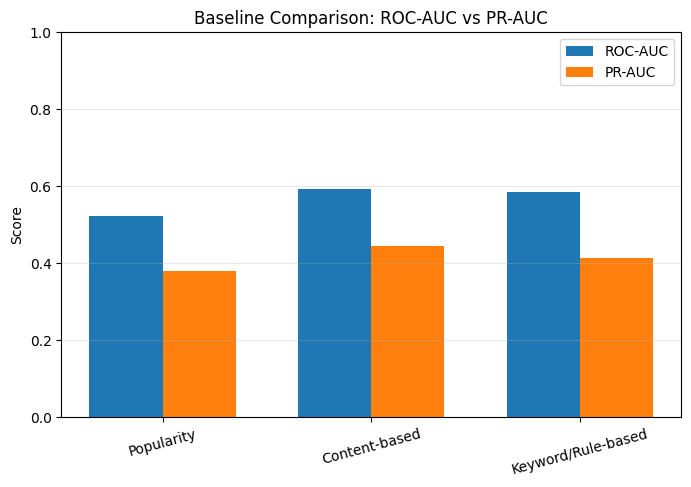

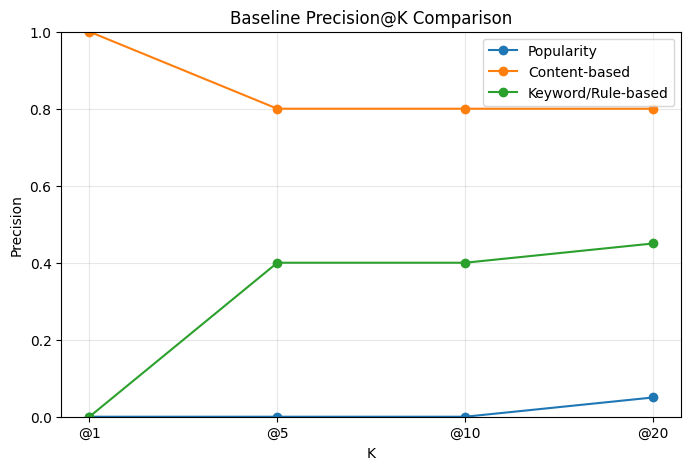

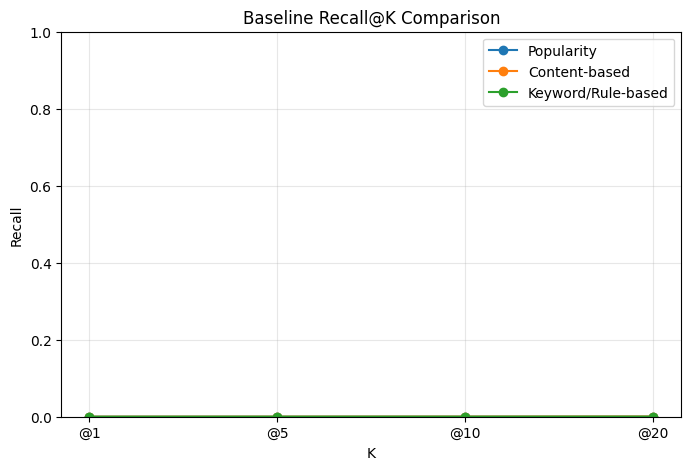

In [12]:
# ---------------------- Visualization of Baseline Results ----------------------
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Re-run evaluation with metric storage instead of only printing ---

def evaluate_and_store_baseline(y_true, scores, model_name, top_k=[1,5,10,20]):
    """Evaluate and return metrics as dict (for visualization)."""
    y_sorted = y_true[np.argsort(-scores)]
    roc_auc = roc_auc_score(y_true, scores)
    pr_auc = average_precision_score(y_true, scores)

    precisions, recalls = [], []
    for k in top_k:
        precisions.append(y_sorted[:k].sum() / k)
        recalls.append(y_sorted[:k].sum() / max(y_true.sum(), 1))

    return {
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "Precision@K": precisions,
        "Recall@K": recalls
    }

# Collect metrics for all baselines
baseline_results = {
    "Popularity": evaluate_and_store_baseline(y_val, pop_scores_val, "Popularity"),
    "Content-based": evaluate_and_store_baseline(y_val, content_scores_val, "Content-based"),
    "Keyword/Rule-based": evaluate_and_store_baseline(y_val, keyword_scores_val, "Keyword/Rule-based"),
}

# --- Step 2: Visualization Function ---
def visualize_model_comparison(results_dict, k_labels=["@1", "@5", "@10", "@20"], save=False):
    models = list(results_dict.keys())
    roc_auc = [results_dict[m]["ROC-AUC"] for m in models]
    pr_auc = [results_dict[m]["PR-AUC"] for m in models]

    # --- AUC comparison ---
    x = np.arange(len(models))
    width = 0.35
    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, roc_auc, width, label='ROC-AUC')
    plt.bar(x + width/2, pr_auc, width, label='PR-AUC')
    plt.xticks(x, models, rotation=15)
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.title("Baseline Comparison: ROC-AUC vs PR-AUC")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    if save:
        plt.savefig("baseline_auc_comparison.png", bbox_inches="tight")
    plt.show()

    # --- Precision@K ---
    plt.figure(figsize=(8, 5))
    for m in models:
        plt.plot(k_labels, results_dict[m]["Precision@K"], marker='o', label=m)
    plt.title("Baseline Precision@K Comparison")
    plt.xlabel("K")
    plt.ylabel("Precision")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(alpha=0.3)
    if save:
        plt.savefig("baseline_precision_comparison.png", bbox_inches="tight")
    plt.show()

    # --- Recall@K ---
    plt.figure(figsize=(8, 5))
    for m in models:
        plt.plot(k_labels, results_dict[m]["Recall@K"], marker='o', label=m)
    plt.title("Baseline Recall@K Comparison")
    plt.xlabel("K")
    plt.ylabel("Recall")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(alpha=0.3)
    if save:
        plt.savefig("baseline_recall_comparison.png", bbox_inches="tight")
    plt.show()

# --- Step 3: Run visualization ---
visualize_model_comparison(baseline_results)


Shape after feature selection: Train: (221860, 7), Val: (93082, 7), Test: (93082, 7)
Selected features (7): ['director_popularity', 'genre_overlap', 'recency_score', 'vote_average', 'similarity', 'runtime_norm', 'cast_popularity']
Dropped features (3): ['popularity', 'genre_score', 'overview_sentiment']


/tmp/ipython-input-2081374709.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='feature', y='importance', data=feat_importance_df, palette='viridis')


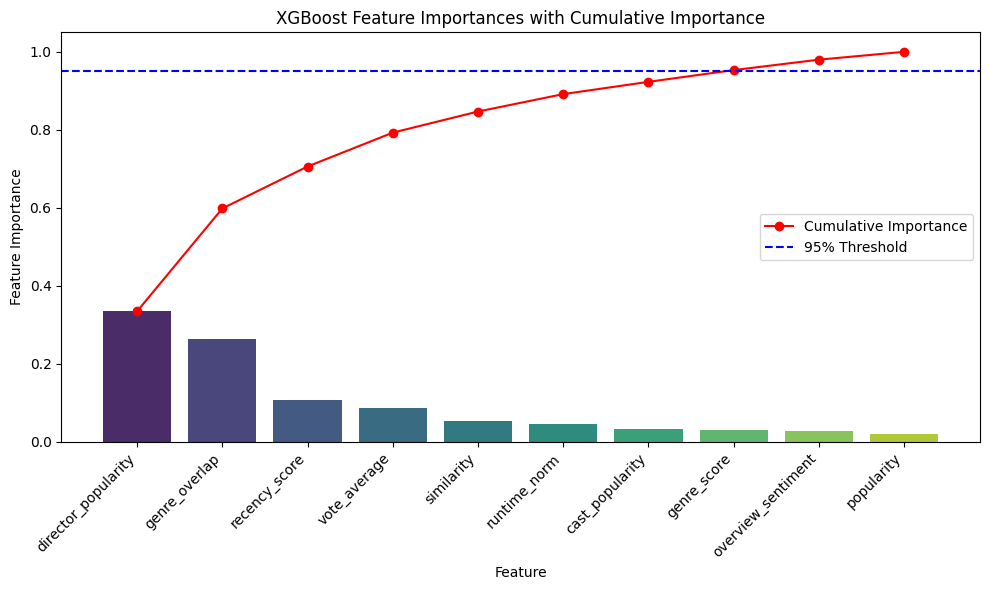

In [13]:
import xgboost as xgb
import numpy as np
import pandas as pd

# Train temporary XGBoost on resampled/scaled data
xgb_temp = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb_temp.fit(X_train_res, y_train_res)

# Get feature importances
importances = xgb_temp.feature_importances_
feat_importance_df = pd.DataFrame({
    'feature': FEAT_COLS,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Compute cumulative importance
feat_importance_df['cumulative_importance'] = feat_importance_df['importance'].cumsum()

# Select features contributing up to 95% of total importance
threshold = 0.95
selected_features = feat_importance_df[feat_importance_df['cumulative_importance'] <= threshold]['feature'].tolist()

# Transform training and validation sets
selected_idx = [FEAT_COLS.index(f) for f in selected_features]
X_train_sel = X_train_res[:, selected_idx]
X_val_sel = X_val_scaled[:, selected_idx]
X_test_sel = X_test_scaled[:, selected_idx]

print(f"Shape after feature selection: Train: {X_train_sel.shape}, Val: {X_val_sel.shape}, Test: {X_test_sel.shape}")

import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance table
feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False)
feat_importance_df['cumulative_importance'] = feat_importance_df['importance'].cumsum()

# Display features kept and dropped
kept_features = feat_importance_df[feat_importance_df['cumulative_importance'] <= threshold]['feature'].tolist()
dropped_features = [f for f in FEAT_COLS if f not in kept_features]

print(f"Selected features ({len(kept_features)}): {kept_features}")
print(f"Dropped features ({len(dropped_features)}): {dropped_features}")

# Cumulative importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x='feature', y='importance', data=feat_importance_df, palette='viridis')
plt.plot(range(len(feat_importance_df)), feat_importance_df['cumulative_importance'], color='red', marker='o', label='Cumulative Importance')
plt.axhline(y=threshold, color='blue', linestyle='--', label=f'{int(threshold*100)}% Threshold')
plt.xticks(rotation=45, ha='right')
plt.title('XGBoost Feature Importances with Cumulative Importance')
plt.ylabel('Feature Importance')
plt.xlabel('Feature')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Use only the selected features
X_train_final = X_train_sel  # already selected and resampled
y_train_final = y_train_res
X_val_final = X_val_sel
y_val_final = y_val

# Define XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',  # can also use 'average_precision'
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearch
grid_search.fit(X_train_final, y_train_final)

# Best parameters and score
print("\n=== Best Hyperparameters ===")
print(grid_search.best_params_)
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

# Train final model with best parameters on full training set
xgb_final = xgb.XGBClassifier(
    **grid_search.best_params_,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_final.fit(X_train_final, y_train_final, eval_set=[(X_val_final, y_val_final)], verbose=True)


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:03:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Best Hyperparameters ===
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best CV ROC-AUC: 0.7624
[0]	validation_0-logloss:0.68840
[1]	validation_0-logloss:0.68457
[2]	validation_0-logloss:0.68173
[3]	validation_0-logloss:0.67956
[4]	validation_0-logloss:0.67782
[5]	validation_0-logloss:0.67649


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:03:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[6]	validation_0-logloss:0.67553
[7]	validation_0-logloss:0.67472
[8]	validation_0-logloss:0.67422
[9]	validation_0-logloss:0.67382
[10]	validation_0-logloss:0.67320
[11]	validation_0-logloss:0.67293
[12]	validation_0-logloss:0.67251
[13]	validation_0-logloss:0.67206
[14]	validation_0-logloss:0.67161
[15]	validation_0-logloss:0.67160
[16]	validation_0-logloss:0.67131
[17]	validation_0-logloss:0.67116
[18]	validation_0-logloss:0.67070
[19]	validation_0-logloss:0.66943
[20]	validation_0-logloss:0.66954
[21]	validation_0-logloss:0.66947
[22]	validation_0-logloss:0.66841
[23]	validation_0-logloss:0.66756
[24]	validation_0-logloss:0.66659
[25]	validation_0-logloss:0.66628
[26]	validation_0-logloss:0.66580
[27]	validation_0-logloss:0.66554
[28]	validation_0-logloss:0.66472
[29]	validation_0-logloss:0.66419
[30]	validation_0-logloss:0.66374
[31]	validation_0-logloss:0.66352
[32]	validation_0-logloss:0.66331
[33]	validation_0-logloss:0.66204
[34]	validation_0-logloss:0.66192
[35]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [15]:
# ---------------------- Evaluation on Validation (Final Model) ----------------------
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import numpy as np

def evaluate_model_final(model, X, y, dataset_name="Validation"):
    """
    Evaluate final XGBoost model with selected features.
    Computes classification report, ROC-AUC, PR-AUC, Precision@K, Recall@K.
    """
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    print(f"\n=== {dataset_name} Classification Report ===")
    print(classification_report(y, y_pred))

    roc_auc = roc_auc_score(y, y_proba)
    pr_auc = average_precision_score(y, y_proba)
    print(f"{dataset_name} ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

    # Precision@K and Recall@K
    top_k = [1, 5, 10, 20]
    sorted_idx = np.argsort(-y_proba)
    y_sorted = y[sorted_idx]

    print(f"\n{dataset_name} Precision@K:")
    for k in top_k:
        p_at_k = y_sorted[:k].sum() / k
        print(f"  P@{k}: {p_at_k:.4f}")

    print(f"{dataset_name} Recall@K:")
    for k in top_k:
        r_at_k = y_sorted[:k].sum() / max(y.sum(), 1)
        print(f"  R@{k}: {r_at_k:.4f}")

# Evaluate the final tuned model on validation set
evaluate_model_final(xgb_final, X_val_final, y_val_final, dataset_name="Validation")



=== Validation Classification Report ===
              precision    recall  f1-score   support

           0       0.68      0.82      0.74     59527
           1       0.50      0.31      0.39     33555

    accuracy                           0.64     93082
   macro avg       0.59      0.57      0.56     93082
weighted avg       0.61      0.64      0.61     93082

Validation ROC-AUC: 0.5936, PR-AUC: 0.4478

Validation Precision@K:
  P@1: 1.0000
  P@5: 0.8000
  P@10: 0.5000
  P@20: 0.4500
Validation Recall@K:
  R@1: 0.0000
  R@5: 0.0001
  R@10: 0.0001
  R@20: 0.0003


In [44]:
KNOWN_GENRES = [
    "action", "adventure", "animation", "comedy", "crime", "documentary",
    "drama", "family", "fantasy", "history", "horror", "music",
    "mystery", "romance", "sci-fi", "thriller", "war", "western"
]

def compute_genre_match(movie_genres, query):
    movie_genres_set = set(str(movie_genres).lower().split())
    query_genres_set = set([g for g in KNOWN_GENRES if g in query.lower()])
    overlap = len(movie_genres_set & query_genres_set) / max(1, len(query_genres_set))
    return overlap

def compute_relevance(genre_match):
    if genre_match >= 0.75:
        return "High"
    elif genre_match >= 0.25:
        return "Medium"
    else:
        return "Low"

# --- Popularity-based ---
def recommend_popularity(movies_df, query="", top_k=5):
    # Normalize popularity
    pop_scores = movies_df['popularity']
    pop_scores = (pop_scores - pop_scores.min()) / max(pop_scores.max() - pop_scores.min(), 1e-8)

    top_idx = pop_scores.nlargest(top_k).index
    results = []
    for idx in top_idx:
        movie = movies_df.iloc[idx]
        genre_match = compute_genre_match(movie['genres'], query)
        relevance = compute_relevance(genre_match)
        results.append({
            "movie_idx": idx,
            "pred_score": pop_scores[idx],
            "genre_match": genre_match,
            "relevance": relevance
        })
    return results

# --- Keyword/Rule-based ---
def recommend_keyword(query, movies_df, top_k=5):
    query_keywords = set(query.lower().split())
    sims = [
        len(set(str(movie['text']).lower().split()) & query_keywords) / max(1, len(query_keywords))
        for _, movie in movies_df.iterrows()
    ]
    sims = np.array(sims)
    top_idx = sims.argsort()[-top_k:][::-1]

    results = []
    for idx in top_idx:
        movie = movies_df.iloc[idx]
        genre_match = compute_genre_match(movie['genres'], query)
        relevance = compute_relevance(genre_match)
        results.append({
            "movie_idx": idx,
            "pred_score": sims[idx],
            "genre_match": genre_match,
            "relevance": relevance
        })
    return results

# --- Content-based (embedding similarity) ---
def recommend_content(query, movies_df, embedding_model, movie_embeddings, top_k=5):
    from sklearn.metrics.pairwise import cosine_similarity
    q_emb = embedding_model.encode([query])
    sims = cosine_similarity(q_emb, movie_embeddings)[0]
    sims = (sims - sims.min()) / max(sims.max() - sims.min(), 1e-8)  # normalize to 0-1
    top_idx = sims.argsort()[-top_k:][::-1]

    results = []
    for idx in top_idx:
        movie = movies_df.iloc[idx]
        genre_match = compute_genre_match(movie['genres'], query)
        relevance = compute_relevance(genre_match)
        results.append({
            "movie_idx": idx,
            "pred_score": sims[idx],
            "genre_match": genre_match,
            "relevance": relevance
        })
    return results


In [45]:
def recommend_ablation(
    query,
    xgb_model,
    movies_df,
    selected_features,
    embedding_model,
    movie_embeddings,
    top_k=10,
    use_rag=True,
    remove_sentiment=False,
    keyword_only=False
):
    """
    Recommend top_k movies with ablation options.

    Ablations:
    - use_rag: if False → LLM-only (no RAG features)
    - remove_sentiment: if True → exclude sentiment feature
    - keyword_only: if True → use keyword-based similarity instead of dense embeddings
    """

    from sklearn.metrics.pairwise import cosine_similarity

    # --- Compute similarity ---
    if keyword_only:
        # Keyword overlap instead of embedding similarity
        query_keywords = set(query.lower().split())
        sims = [
            len(set(str(movie['text']).lower().split()) & query_keywords) / max(1, len(query_keywords))
            for _, movie in movies_df.iterrows()
        ]
        sims = np.array(sims)
    else:
        # Dense embedding similarity (RAG / LLM-based)
        q_emb = embedding_model.encode([query])
        sims = cosine_similarity(q_emb, movie_embeddings)[0]

    # --- Compute scores ---
    scores = []
    for i, movie in movies_df.iterrows():
        genre_overlap = len(set(movie['genres'].lower().split()) &
                            set([g for g in KNOWN_GENRES if g in query.lower()])) / max(1, len(query.split()))

        # Build feature vector dynamically
        feat = {
            'similarity': sims[i],
            'vote_average': movie.get('vote_average', 5.0),
            'popularity': movie.get('popularity', 1.0),
            'genre_overlap': genre_overlap,
            'recency_score': movie.get('recency_score', 0.5),
            'runtime_norm': movie.get('runtime_norm', 0.5),
            'cast_popularity': movie.get('cast_popularity', 0.5),
            'director_popularity': movie.get('director_popularity', 0.5),
            'genre_score': movie.get('genre_score', 0.5),
            'overview_sentiment': movie.get('overview_sentiment', 0.5)
        }

        # Apply ablations
        if remove_sentiment:
            feat.pop('overview_sentiment', None)
        if not use_rag:
            score = feat['similarity']
        else:
            vec = np.array([feat[f] for f in selected_features if f in feat]).reshape(1, -1)
            score = xgb_model.predict_proba(vec)[:, 1][0]
        scores.append(score)

    scores = np.array(scores)
    top_indices = np.argsort(-scores)[:top_k]

    # --- Build results as dictionaries ---
    results = []
    for idx in top_indices:
        movie = movies_df.iloc[idx]
        genre_overlap = len(set(movie['genres'].lower().split()) &
                            set([g for g in KNOWN_GENRES if g in query.lower()])) / max(1, len(query.split()))

        relevance = "High" if genre_overlap >= 0.75 else ("Medium" if genre_overlap >= 0.25 else "Low")

        results.append({
            "movie_idx": idx,
            "title": movie.get("title", "Unknown"),
            "pred_score": scores[idx],
            "genre_match": genre_overlap,
            "relevance": relevance
        })

    return results


In [46]:
model = SentenceTransformer('all-MiniLM-L6-v2')


=== XGB Full Model ===
ROC-AUC: 0.5234, PR-AUC: 0.3832
P@1: 0.0000, R@1: 0.0000
P@5: 0.4000, R@5: 0.0001
P@10: 0.5000, R@10: 0.0001
P@20: 0.4500, R@20: 0.0003

=== XGB (No Sentiment) ===
ROC-AUC: 0.5234, PR-AUC: 0.3832
P@1: 0.0000, R@1: 0.0000
P@5: 0.4000, R@5: 0.0001
P@10: 0.5000, R@10: 0.0001
P@20: 0.4500, R@20: 0.0003

=== XGB (Keyword-only) ===
ROC-AUC: 0.5066, PR-AUC: 0.3755
P@1: 0.0000, R@1: 0.0000
P@5: 0.4000, R@5: 0.0001
P@10: 0.5000, R@10: 0.0001
P@20: 0.5000, R@20: 0.0003

=== LLM-only (No RAG) ===
ROC-AUC: 0.4884, PR-AUC: 0.3525
P@1: 0.0000, R@1: 0.0000
P@5: 0.2000, R@5: 0.0000
P@10: 0.5000, R@10: 0.0001
P@20: 0.4500, R@20: 0.0003


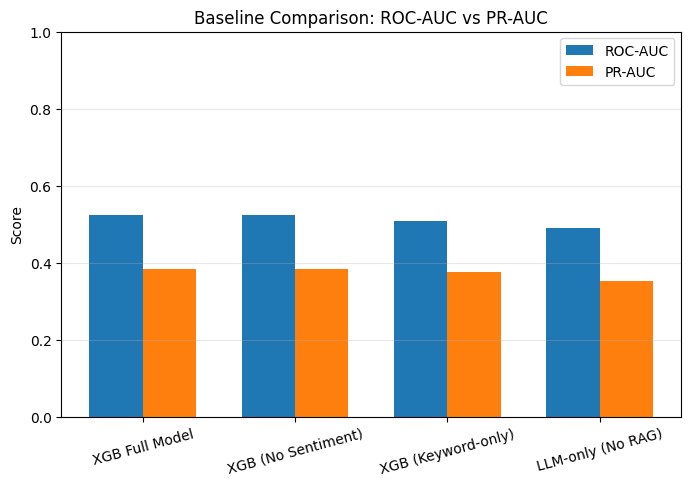

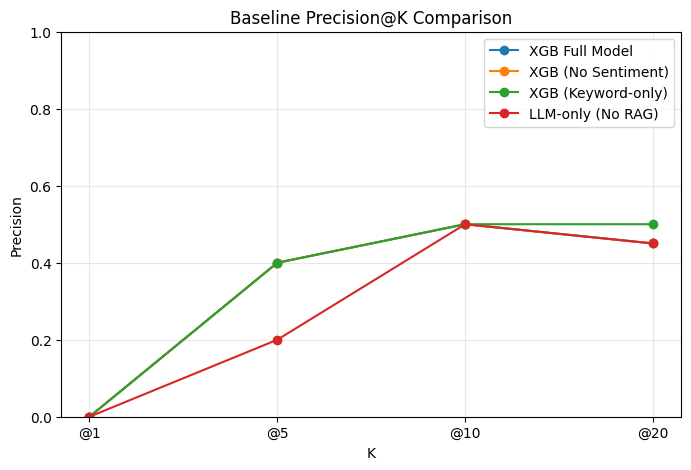

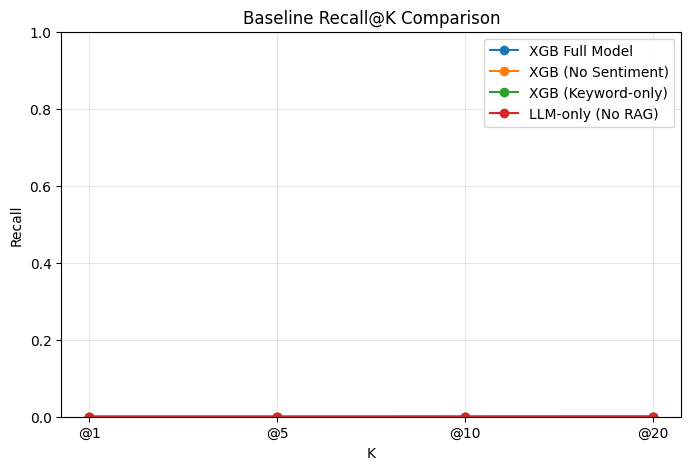

In [47]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd

def evaluate_ablation_variant(X_val, y_val, xgb_model, selected_features,
                              variant_name, remove_sentiment=False, keyword_only=False,
                              use_rag=True, top_k=[1,5,10,20]):
    """
    Evaluate and return metrics + score distributions for XGB ablation variants.
    Handles X_val as numpy array or DataFrame and ensures selected_features are used correctly.
    """
    # --- Convert/Select features ---
    if isinstance(X_val, np.ndarray):
        # Only take as many columns as selected_features
        n_feats = min(X_val.shape[1], len(selected_features))
        X_mod = pd.DataFrame(X_val[:, :n_feats], columns=selected_features[:n_feats])
    else:
        # Select only features present in X_val
        X_mod = X_val[[f for f in selected_features if f in X_val.columns]].copy()

    # --- Apply ablations ---
    if remove_sentiment and 'overview_sentiment' in X_mod.columns:
        X_mod = X_mod.drop(columns=['overview_sentiment'])

    if keyword_only and 'similarity' in X_mod.columns:
        X_mod['similarity'] = X_mod.get('keyword_overlap', 0.0)

    # Ensure only existing features are used for XGB
    features_to_use = [f for f in selected_features if f in X_mod.columns]

    # --- Generate scores ---
    if use_rag and features_to_use:
        scores = xgb_model.predict_proba(X_mod[features_to_use])[:, 1]
    else:
        # LLM-only fallback
        scores = X_mod['similarity'].values if 'similarity' in X_mod.columns else np.zeros(len(X_mod))

    # --- Compute metrics ---
    roc_auc = roc_auc_score(y_val, scores)
    pr_auc = average_precision_score(y_val, scores)
    y_sorted = y_val[np.argsort(-scores)]

    precisions, recalls = [], []
    for k in top_k:
        precisions.append(y_sorted[:k].sum() / k)
        recalls.append(y_sorted[:k].sum() / max(y_val.sum(), 1))

    metrics = {
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "Precision@K": precisions,
        "Recall@K": recalls,
        "Scores": scores
    }

    # --- Print summary ---
    print(f"\n=== {variant_name} ===")
    print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
    for k, p, r in zip(top_k, precisions, recalls):
        print(f"P@{k}: {p:.4f}, R@{k}: {r:.4f}")

    return metrics


ablation_results = {
    "XGB Full Model": evaluate_ablation_variant(X_val, y_val, xgb_final, selected_features, "XGB Full Model"),
    "XGB (No Sentiment)": evaluate_ablation_variant(X_val, y_val, xgb_final, selected_features, "XGB (No Sentiment)", remove_sentiment=True),
    "XGB (Keyword-only)": evaluate_ablation_variant(X_val, y_val, xgb_final, selected_features, "XGB (Keyword-only)", keyword_only=True),
    "LLM-only (No RAG)": evaluate_ablation_variant(X_val, y_val, xgb_final, selected_features, "LLM-only (No RAG)", use_rag=False),
}

visualize_model_comparison(ablation_results)


In [51]:
queries = [
    "romantic comedy",
    "sci-fi thriller about space exploration",
    "feel-good family movie",
]

model_variants = {
    # 🔹 Baselines
    "Popularity-based": {"method": "popularity"},
    "Keyword/Rule-based": {"method": "keyword"},
    "Content-based": {"method": "content"},

    # 🔹 Ablations / XGB variants
    "XGB Full Model": {"use_rag": True, "remove_sentiment": False, "keyword_only": False},
    "XGB (No Sentiment)": {"use_rag": True, "remove_sentiment": True, "keyword_only": False},
    "XGB (Keyword-only)": {"use_rag": False, "remove_sentiment": False, "keyword_only": True},
    "LLM-only (No RAG)": {"use_rag": False, "remove_sentiment": False, "keyword_only": False}
}

results = []

for query in queries:
    print(f"\n===== Query: '{query}' =====")

    for variant_name, params in model_variants.items():
        print(f"\n--- Model: {variant_name} ---")

        # --- Baselines ---
        if params.get("method") == "popularity":
            top_recs = recommend_popularity(movies_feedback, top_k=5, query=query)


        elif params.get("method") == "keyword":
            top_recs = recommend_keyword(query, movies_feedback, top_k=5)

        elif params.get("method") == "content":
            top_recs = recommend_content(
                query,
                movies_feedback,
                embedding_model=model,
                movie_embeddings=movie_embeddings,
                top_k=5
            )

        # --- Ablation / XGB Variants ---
        else:
            top_recs = recommend_ablation(
                query=query,
                xgb_model=xgb_final,
                movies_df=movies_feedback,
                selected_features=selected_features,
                embedding_model=model,
                movie_embeddings=movie_embeddings,
                top_k=5,
                **params
            )

        # --- Store results ---
        for rec in top_recs:
            results.append({
                "query": query,
                "variant": variant_name,
                "title": movies_feedback.iloc[rec["movie_idx"]]["title"],
                "score": rec["pred_score"],
                "genre_match": rec.get("genre_match"),
                "relevance": rec.get("relevance")
            })

        # --- Print summary ---
        for rec in top_recs:
            idx = rec['movie_idx']
            print(
                f"Movie: {movies_feedback.iloc[idx]['title']}, "
                f"Score: {rec['pred_score']:.4f}, "
                f"Genre Match: {rec.get('genre_match', np.nan):.2f}, "
                f"Relevance: {rec.get('relevance', 'N/A')}"
            )

# Convert to DataFrame for further analysis or visualization
results_df = pd.DataFrame(results)



===== Query: 'romantic comedy' =====

--- Model: Popularity-based ---
Movie: Minions, Score: 1.0000, Genre Match: 1.00, Relevance: High
Movie: Wonder Woman, Score: 0.5376, Genre Match: 0.00, Relevance: Low
Movie: Beauty and the Beast, Score: 0.5247, Genre Match: 0.00, Relevance: Low
Movie: Baby Driver, Score: 0.4165, Genre Match: 0.00, Relevance: Low
Movie: Big Hero 6, Score: 0.3906, Genre Match: 1.00, Relevance: High

--- Model: Keyword/Rule-based ---
Movie: Someone Like You..., Score: 1.0000, Genre Match: 1.00, Relevance: High
Movie: Ecstasy, Score: 1.0000, Genre Match: 1.00, Relevance: High
Movie: Love, Score: 1.0000, Genre Match: 0.00, Relevance: Low
Movie: Woman of the Year, Score: 1.0000, Genre Match: 1.00, Relevance: High
Movie: The World's Greatest Lover, Score: 1.0000, Genre Match: 1.00, Relevance: High

--- Model: Content-based ---
Movie: Made For Each Other, Score: 1.0000, Genre Match: 1.00, Relevance: High
Movie: Love's Routine, Score: 0.9181, Genre Match: 1.00, Relevance:

/tmp/ipython-input-4013697437.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="variant", y="score", palette="pastel")


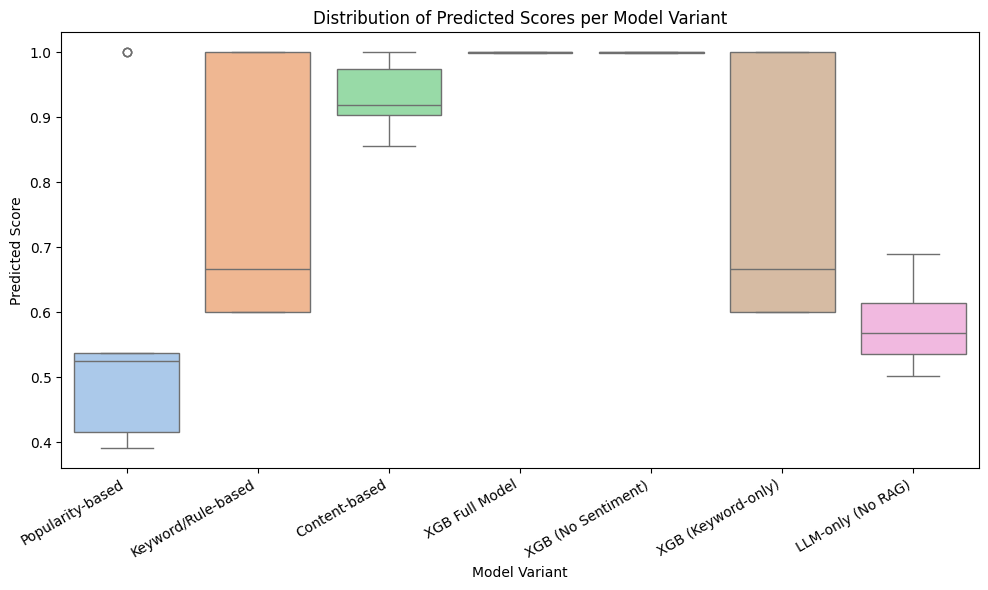

/tmp/ipython-input-4013697437.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x="query", y="score", palette="light:#5A9")


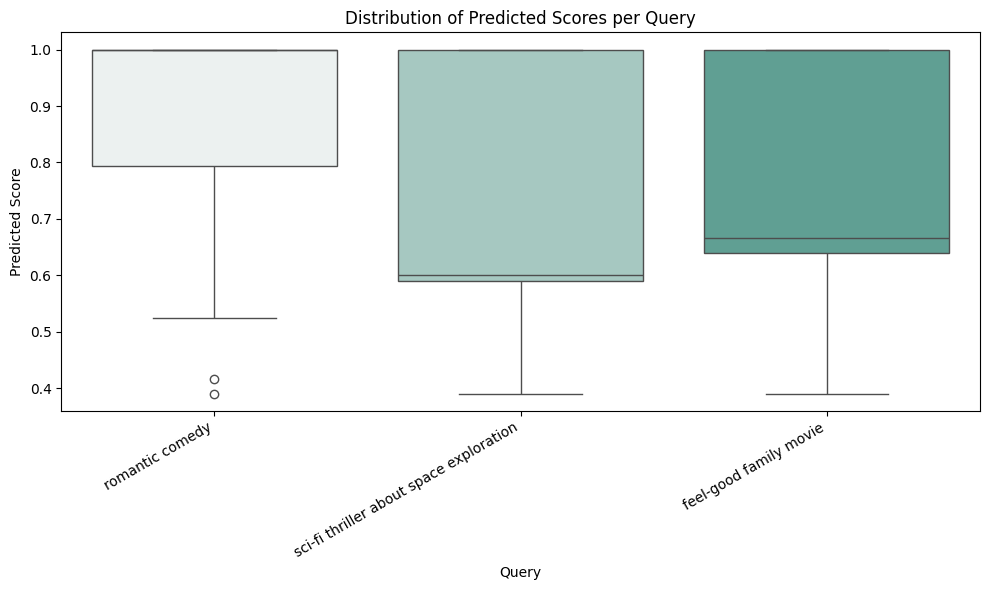

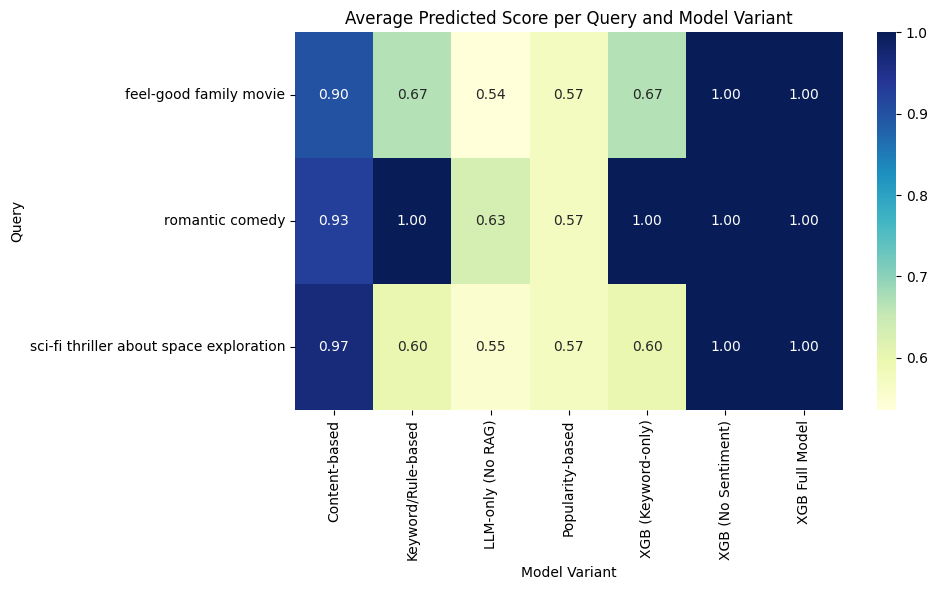

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x="variant", y="score", palette="pastel")
plt.xticks(rotation=30, ha='right')
plt.title("Distribution of Predicted Scores per Model Variant")
plt.ylabel("Predicted Score")
plt.xlabel("Model Variant")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x="query", y="score", palette="light:#5A9")
plt.xticks(rotation=30, ha='right')
plt.title("Distribution of Predicted Scores per Query")
plt.ylabel("Predicted Score")
plt.xlabel("Query")
plt.tight_layout()
plt.show()

heatmap_data = results_df.groupby(["query", "variant"])["score"].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Predicted Score per Query and Model Variant")
plt.xlabel("Model Variant")
plt.ylabel("Query")
plt.tight_layout()
plt.show()


In [70]:
import numpy as np
import pandas as pd

# Choose which K you care about (e.g., K=5 → index 1 in [1,5,10,20])
k_index = 2  # corresponds to Precision@5

all_results = []

# Ablation/XGB variants
for model_name, metrics in ablation_results.items():
    all_results.append({
        "model": model_name,
        "Precision@5": metrics["Precision@K"][k_index],
        "ROC-AUC": metrics["ROC-AUC"],
        "PR-AUC": metrics["PR-AUC"]
    })

# Baselines
for model_name, metrics in baseline_results.items():
    all_results.append({
        "model": model_name,
        "Precision@5": metrics["Precision@K"][k_index],
        "ROC-AUC": metrics["ROC-AUC"],
        "PR-AUC": metrics["PR-AUC"]
    })

combined_df = pd.DataFrame(all_results).sort_values("Precision@5", ascending=False)
print(combined_df)

best_model_name = combined_df.iloc[0]["model"]
best_precision = combined_df.iloc[0]["Precision@5"]
print(f"\nBest model by Precision@5: {best_model_name} (Precision@5 = {best_precision:.4f})")


                model  Precision@5   ROC-AUC    PR-AUC
5       Content-based          0.8  0.592011  0.444825
1  XGB (No Sentiment)          0.5  0.523351  0.383186
0      XGB Full Model          0.5  0.523351  0.383186
2  XGB (Keyword-only)          0.5  0.506556  0.375544
3   LLM-only (No RAG)          0.5  0.488412  0.352511
6  Keyword/Rule-based          0.4  0.584644  0.414838
4          Popularity          0.0  0.522896  0.380322

Best model by Precision@5: Content-based (Precision@5 = 0.8000)


Total False Positives: 2342
Total False Negatives: 31215

Top False Negatives (missed positives):
query
short romantic drama      16204
sci-fi space adventure    15011
Name: count, dtype: int64

Top False Positives (wrongly predicted as positive):
query
short romantic drama      2335
sci-fi space adventure       7
Name: count, dtype: int64


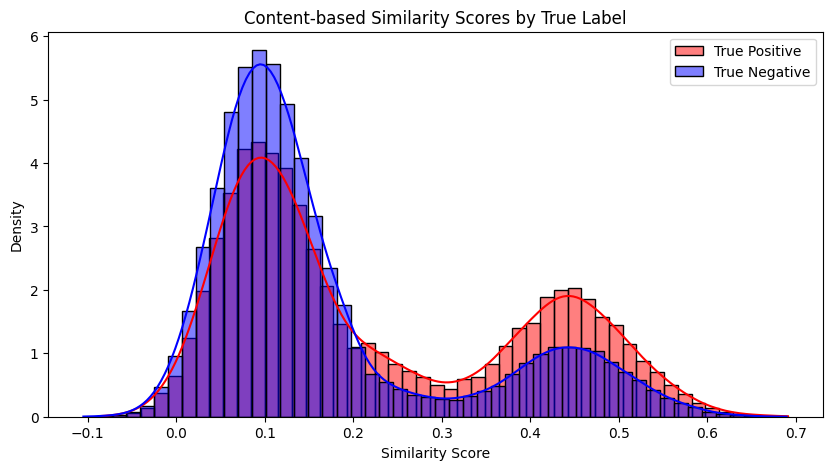

In [72]:
# ---------------------- Error Analysis: Content-based Model ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get similarity scores for validation set
content_scores_val = content_scores_val  # your precomputed content-based similarity scores
y_true = y_val_final  # true labels

# Define threshold for positive recommendation
threshold = 0.5
y_pred = (content_scores_val >= threshold).astype(int)

# Build analysis DataFrame
val_analysis = pd.DataFrame({
    'query': val_df['query'].values,
    'true_label': y_true,
    'pred_label': y_pred,
    'pred_score': content_scores_val
})

# False positives / negatives
false_positives = val_analysis[(val_analysis['true_label']==0) & (val_analysis['pred_label']==1)]
false_negatives = val_analysis[(val_analysis['true_label']==1) & (val_analysis['pred_label']==0)]

print(f"Total False Positives: {len(false_positives)}")
print(f"Total False Negatives: {len(false_negatives)}")

print("\nTop False Negatives (missed positives):")
print(false_negatives['query'].value_counts().head(10))

print("\nTop False Positives (wrongly predicted as positive):")
print(false_positives['query'].value_counts().head(10))

# Prediction score distribution
plt.figure(figsize=(10,5))
sns.histplot(val_analysis[val_analysis['true_label']==1]['pred_score'], color='red', label='True Positive', kde=True, stat='density', bins=50)
sns.histplot(val_analysis[val_analysis['true_label']==0]['pred_score'], color='blue', label='True Negative', kde=True, stat='density', bins=50)
plt.title('Content-based Similarity Scores by True Label')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.legend()
plt.show()





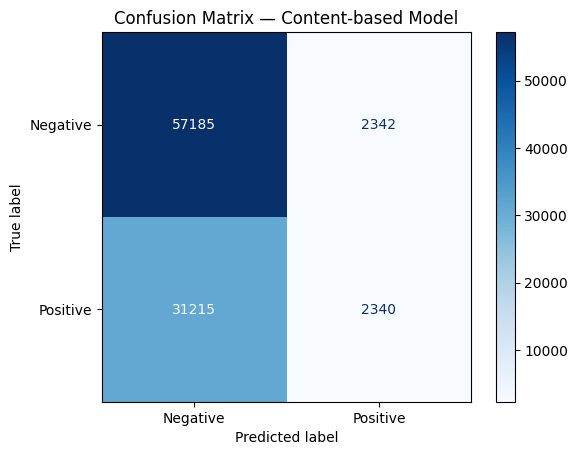

In [73]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(val_analysis['true_label'], val_analysis['pred_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative','Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix — Content-based Model')
plt.show()


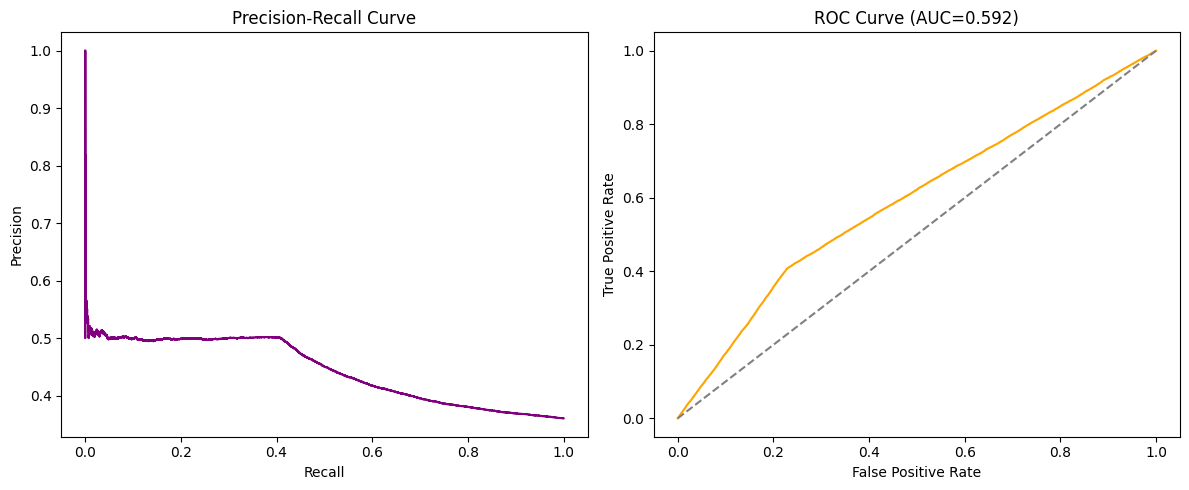

In [74]:
# Precision-Recall and ROC curves
from sklearn.metrics import precision_recall_curve, roc_curve, auc

precision, recall, _ = precision_recall_curve(val_analysis['true_label'], val_analysis['pred_score'])
fpr, tpr, _ = roc_curve(val_analysis['true_label'], val_analysis['pred_score'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(recall, precision, color='purple')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")

plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='orange')
plt.plot([0,1],[0,1],'--',color='gray')
plt.title(f"ROC Curve (AUC={roc_auc:.3f})")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()


Mean Feature Values by Error Type (Content-based Model):
            director_popularity  genre_overlap  recency_score  vote_average  \
error_type                                                                    
FN                       -0.001          0.524         -0.022         0.011   
FP                       -0.079          3.473          0.018         0.104   
correct                   0.007          0.357          0.009        -0.014   

            similarity  runtime_norm  cast_popularity  
error_type                                             
FN              -0.097         0.003            0.049  
FP               1.545         0.190            0.033  
correct         -0.069        -0.016           -0.027  


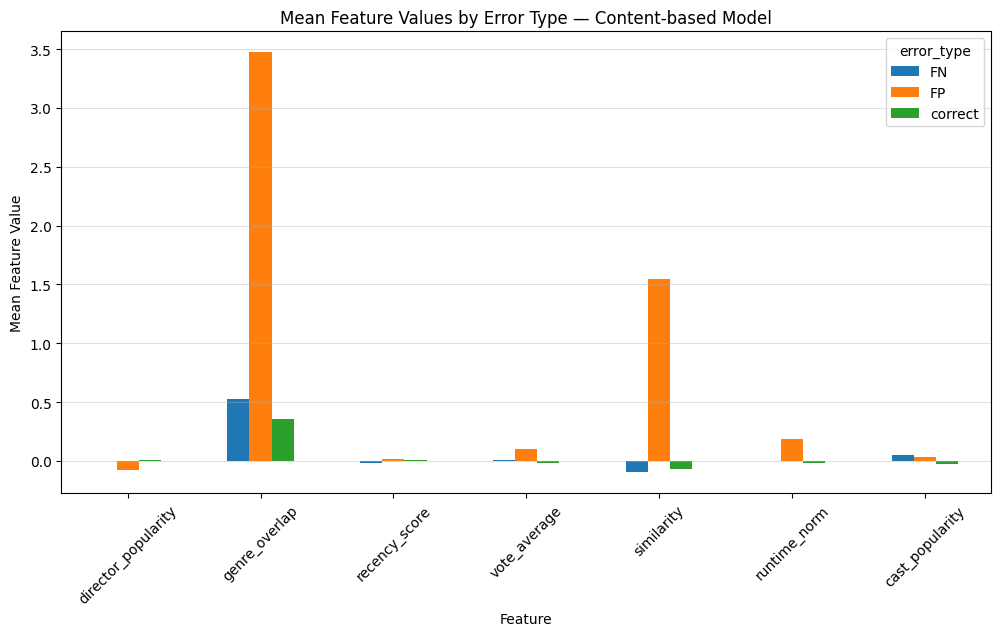

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume:
# - y_val_final : ground-truth relevance labels (1 = relevant)
# - content_scores_val : predicted similarity scores from content-based model
# - X_val_final : validation feature matrix (e.g., genre_overlap, recency_score, etc.)
# - selected_features : list of feature names used in content model

# Threshold for deciding "recommended" (e.g., top 10% or 0.5 cutoff)
threshold = np.percentile(content_scores_val, 90)  # top 10% as positives
y_pred_content = (content_scores_val >= threshold).astype(int)

# --- Construct analysis DataFrame ---
val_analysis_content = pd.DataFrame({
    'true_label': y_val_final,
    'pred_label': y_pred_content
})

# Add feature values
feat_errors = pd.DataFrame(X_val_final, columns=selected_features)
feat_errors['error_type'] = 'correct'

# Identify FPs and FNs
false_positives = val_analysis_content[
    (val_analysis_content['true_label'] == 0) & (val_analysis_content['pred_label'] == 1)
].index
false_negatives = val_analysis_content[
    (val_analysis_content['true_label'] == 1) & (val_analysis_content['pred_label'] == 0)
].index

# Label rows
feat_errors.loc[false_positives, 'error_type'] = 'FP'
feat_errors.loc[false_negatives, 'error_type'] = 'FN'

# --- Compute mean feature values by error type ---
mean_feat_by_error = feat_errors.groupby('error_type')[selected_features].mean()

print("\nMean Feature Values by Error Type (Content-based Model):")
print(mean_feat_by_error.round(3))

# --- Visualize feature differences ---
mean_feat_by_error.T.plot(kind='bar', figsize=(12,6))
plt.title('Mean Feature Values by Error Type — Content-based Model')
plt.ylabel('Mean Feature Value')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.4)
plt.show()
